In [3]:
import numpy as np
from qiskit import *

In [15]:
from qiskit.circuit import Gate

gate1 = Gate(name='gate1', num_qubits=2, params=[])

In [18]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(gate1, [qr[0], qr[1]])
circ.append(gate1, [qr[1], qr[2]])

circ.draw()

┌────────┐          
q_0: ┤0       ├──────────
     │  gate1 │┌────────┐
q_1: ┤1       ├┤0       ├
     └────────┘│  gate1 │
q_2: ──────────┤1       ├
               └────────┘

In [19]:
# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u(1, 2, -2, sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw()

┌───┐                       
q_0: ┤ H ├──■────────────────────
     └───┘┌─┴─┐     ┌───────────┐
q_1: ─────┤ X ├──■──┤0          ├
          └───┘┌─┴─┐│  sub_circ │
q_2: ──────────┤ X ├┤1          ├
               └───┘└───────────┘

In [20]:
#Circuits are not immediatelydecomposed upon conversion to_instruction to allow circuit design at
#higher levels of abstraction. 
#When desired, or before compilation, sub-circuits will be decomposed via the decompose method.
decomposed_circ = circ.decompose() # Does not modify original circuit
decomposed_circ.draw()

┌─────────┐                                        
q_0: ┤ U2(0,π) ├──■─────────────────────────────────────
     └─────────┘┌─┴─┐     ┌───┐          ░ ┌───────────┐
q_1: ───────────┤ X ├──■──┤ H ├────■─────░─┤ U(1,2,-2) ├
                └───┘┌─┴─┐└───┘┌───┴───┐ ░ └───┬───┬───┘
q_2: ────────────────┤ X ├─────┤ Rz(1) ├─░─────┤ I ├────
                     └───┘     └───────┘ ░     └───┘

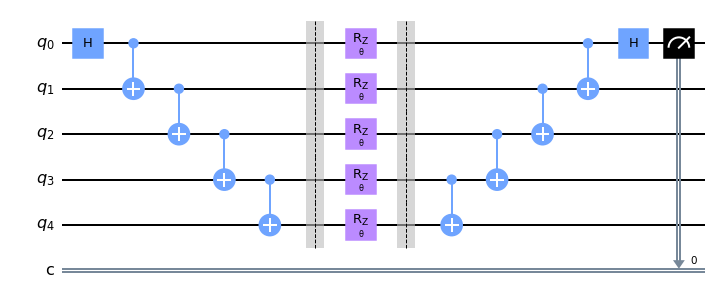

In [8]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

In [9]:
print(qc.parameters)

ParameterView([Parameter(θ)])


In [10]:
#All circuit parameters must be bound before sending the circuit to a backend. 
#This can be done as follows: - The bind_parameters method accepts a dictionary mapping Parameters to values, and returns a new circuit with each parameter replaced by its corresponding value. Partial binding is supported,
#in which case the returned circuit will be parameterized by any Parameters that were not mapped to a value.
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

circuits[-1].draw()

┌───┐                     ░ ┌────────┐ ░                     ┌───┐┌─┐
q_0: ┤ H ├──■──────────────────░─┤ Rz(2π) ├─░──────────────────■──┤ H ├┤M├
     └───┘┌─┴─┐                ░ ├────────┤ ░                ┌─┴─┐└───┘└╥┘
q_1: ─────┤ X ├──■─────────────░─┤ Rz(2π) ├─░─────────────■──┤ X ├──────╫─
          └───┘┌─┴─┐           ░ ├────────┤ ░           ┌─┴─┐└───┘      ║ 
q_2: ──────────┤ X ├──■────────░─┤ Rz(2π) ├─░────────■──┤ X ├───────────╫─
               └───┘┌─┴─┐      ░ ├────────┤ ░      ┌─┴─┐└───┘           ║ 
q_3: ───────────────┤ X ├──■───░─┤ Rz(2π) ├─░───■──┤ X ├────────────────╫─
                    └───┘┌─┴─┐ ░ ├────────┤ ░ ┌─┴─┐└───┘                ║ 
q_4: ────────────────────┤ X ├─░─┤ Rz(2π) ├─░─┤ X ├─────────────────────╫─
                         └───┘ ░ └────────┘ ░ └───┘                     ║ 
c: 1/═══════════════════════════════════════════════════════════════════╩═
                                                                        0

In [11]:
backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

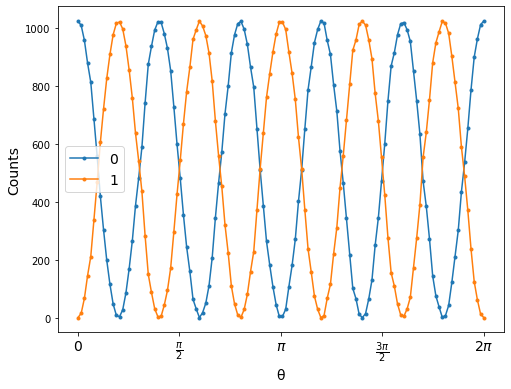

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

In [13]:
#Compiling over a parameterized circuit prior to binding can, 
#in some cases, significantly reduce compilation time as compared to compiling over a set of bound circuits.
import time
from itertools import combinations
from qiskit.compiler import assemble
from qiskit.test.mock import FakeVigo

start = time.time()
qcs = []

theta_range = np.linspace(0, 2*np.pi, 32)

for n in theta_range:
    qc = QuantumCircuit(5)

    for k in range(8):
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)
        qc.rz(n, range(5))
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)

    qcs.append(qc)

compiled_circuits = transpile(qcs, backend=FakeVigo())
qobj = assemble(compiled_circuits, backend=FakeVigo())

end = time.time()
print('Time compiling over set of bound circuits: ', end-start)

Time compiling over set of bound circuits:  20.691713333129883


In [ ]:
start = time.time()
qc = QuantumCircuit(5)
theta = Parameter('theta')

for k in range(8):
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)
    qc.rz(theta, range(5))
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)

transpiled_qc = transpile(qc, backend=FakeVigo())
qobj = assemble([transpiled_qc.bind_parameters({theta: n})
                 for n in theta_range], backend=FakeVigo())
end = time.time()
print('Time compiling over parameterized circuit, then binding: ', end-start)

In [ ]:
# Parameterized circuits can be composed like standard QuantumCircuits.
# Generally, when composing two parameterized circuits, the resulting circuit will be parameterized by the union 
# of the parameters of the input circuits.
# However, parameter names must be unique within a given circuit. 
# When attempting to add a parameter whose name is already present in the target circuit: -
#     if the source and target share the same Parameter instance, the parameters will be assumed to be the same and combined 
#     - if the source and target have different Parameter instances, an error will be raised
phi = Parameter('phi')

sub_circ1 = QuantumCircuit(2, name='sc_1')
sub_circ1.rz(phi, 0)
sub_circ1.rx(phi, 1)

sub_circ2 = QuantumCircuit(2, name='sc_2')
sub_circ2.rx(phi, 0)
sub_circ2.rz(phi, 1)

qc = QuantumCircuit(4)
qr = qc.qregs[0]

qc.append(sub_circ1.to_instruction(), [qr[0], qr[1]])
qc.append(sub_circ2.to_instruction(), [qr[0], qr[1]])

qc.append(sub_circ2.to_instruction(), [qr[2], qr[3]])

print(qc.draw())

# The following raises an error: "QiskitError: 'Name conflict on adding parameter: phi'"
# phi2 = Parameter('phi')
# qc.u3(0.1, phi2, 0.3, 0)

In [ ]:
# To insert a subcircuit undera different parameterization, the to_instruction method accepts an 
# optional argument (parameter_map) which, when present, will generate instructions with the source parameter 
# replaced by a new parameter.

In [14]:
p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])
print(larger_qc.draw())

print(larger_qc.decompose().draw())


         ┌────────────────┐
q2537_0: ┤0               ├
         │                │
q2537_1: ┤1 oracle(theta) ├
         │                │
q2537_2: ┤2               ├
         └┬──────────────┬┘
q2537_3: ─┤0             ├─
          │              │ 
q2537_4: ─┤1 oracle(phi) ├─
          │              │ 
q2537_5: ─┤2             ├─
         ┌┴──────────────┴┐
q2537_6: ┤0               ├
         │                │
q2537_7: ┤1 oracle(gamma) ├
         │                │
q2537_8: ┤2               ├
         └────────────────┘
         ┌───────────┐                                    
q2537_0: ┤ Rz(theta) ├──■─────────────────────────────────
         └───────────┘┌─┴─┐┌───────────┐                  
q2537_1: ─────────────┤ X ├┤ Rz(theta) ├──■───────────────
                      └───┘└───────────┘┌─┴─┐┌───────────┐
q2537_2: ───────────────────────────────┤ X ├┤ Rz(theta) ├
          ┌─────────┐                   └───┘└───────────┘
q2537_3: ─┤ Rz(phi) ├───■──────────────────────────────